In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

## Load MERFISH Data from Existing Study

Plot some gene expression data on the x-y spatial coordinates

raw data dim: (1056, 140)


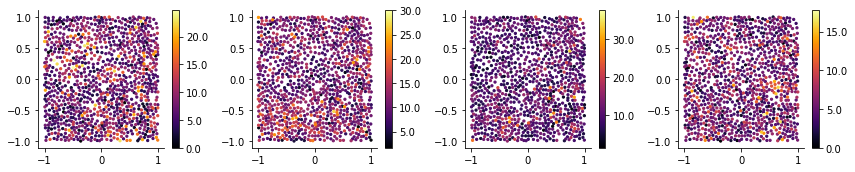

In [3]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from plot_utils import plot_multiple_scatter_continuous

# load the data for a given replicate
ddir = '/Users/jjzhu/Google Drive/_GLISS/data/scGCO'
ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
locs, data = read_spatial_expression(ff,sep=' ')
data_norm = normalize_count_cellranger(data)

# center the locations to zero and 1
loc_df = pd.DataFrame(locs, columns=['x', 'y'])
def center_unit(x):
    shift = (max(x) + min(x)) / 2
    scale = (max(x) - min(x)) / 2
    return (x - shift) / scale
loc_df['x'] = center_unit(loc_df['x'])
loc_df['y'] = center_unit(loc_df['y'])

plt_df = data_norm[data_norm.columns[:4]]
plot_multiple_scatter_continuous(loc_df, plt_df)

## Simulate the Gene Expression Given the Coordinates

### Visualize Noiseless Patterns

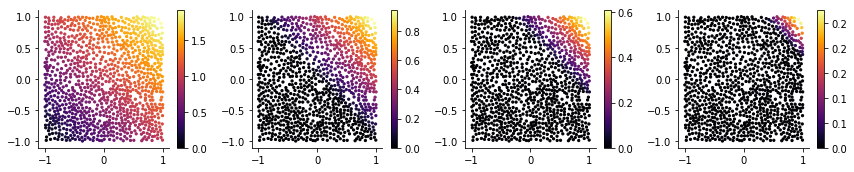

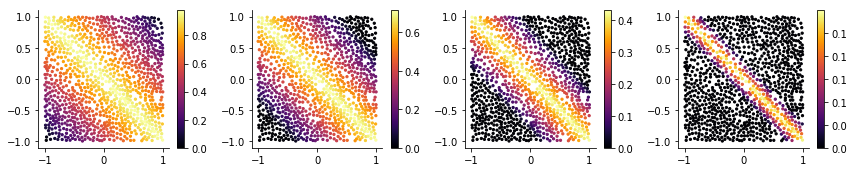

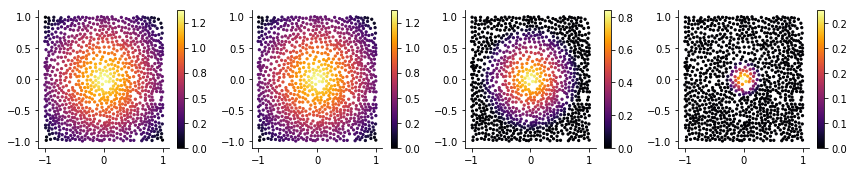

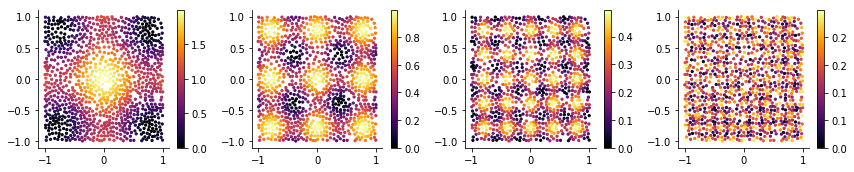

In [4]:
from sim_utils import add_gaussian_noise, multi_2D_pattern
from io_utils import save_data_to_file

# plot noiseless templates
temps = ['linear', 'diaquad', 'radial', 'cosine']
seed = 0
for t in temps:
    tdf = multi_2D_pattern(t, loc_df['x'], loc_df['y'])
    tdf = pd.DataFrame(tdf)
    plot_multiple_scatter_continuous(loc_df, tdf)

### Setup simulation pipeline given parameters

In [5]:
# key parameters
sim_dir = '/Users/jjzhu/Google Drive/_GLISS/data/space_comp_sim/20191104'
save = True

# key functions
def sim_2D_mtx(loc_df, params):
    # extract simulation parameters
    n_per_reg = params['n_per_reg']
    n_reg = params['n_regs']
    seed = params['seed']
    t = params['temp']
    plot = (seed == 0)
    # generate the noiseless SGE patterns
    tdf = multi_2D_pattern(t, loc_df['x'], loc_df['y'], n_regimes=n_reg)
    n_non_nulls = n_per_reg * n_reg
    n_nulls = n_non_nulls
    # generate data matrix with noise
    null_mtx = np.zeros((tdf.shape[0], n_nulls))
    nonnull_mtx = np.repeat(tdf, n_per_reg, axis=1)
    mtx = np.concatenate((nonnull_mtx, null_mtx),axis=1)
    mtx = add_gaussian_noise(mtx, 0.1, seed=seed)
    mtx[mtx < 0] = 0
    # plot the non-nulls for first cases
    if plot:
        print('Num. of nulls: {}; Num. of non-nulls: {}'.format(n_nulls, n_non_nulls))
        print('Generated matrix: {}'.format(mtx.shape))
        plt_df = pd.DataFrame(mtx[:, ::n_per_reg][:, :(n_reg+1)])
        plot_multiple_scatter_continuous(loc_df, plt_df)
    return mtx

def get_fname(sdir, x, pfx, sfx):
    fn = '{}/{}_{}_{}.{}'.format(sdir, pfx, x['temp'], x['seed'], sfx)
    return fn
    

### Run the simulation pipeline and save data to file

(80, 6)


,seed,temp,n_per_reg,n_regs,locs_fn,expr_fn
0,0,linear,25,4,locs_2d.csv,sim_data/mtx_linear_0.csv
1,0,diaquad,25,4,locs_2d.csv,sim_data/mtx_diaquad_0.csv
2,0,radial,25,4,locs_2d.csv,sim_data/mtx_radial_0.csv
3,0,cosine,25,4,locs_2d.csv,sim_data/mtx_cosine_0.csv
4,1,linear,25,4,locs_2d.csv,sim_data/mtx_linear_1.csv


Num. of nulls: 100; Num. of non-nulls: 100
Generated matrix: (1045, 200)


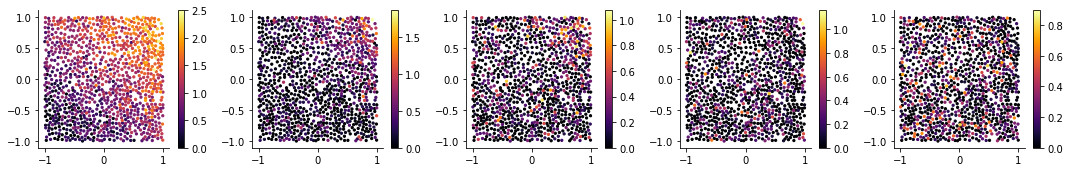

Num. of nulls: 100; Num. of non-nulls: 100
Generated matrix: (1045, 200)


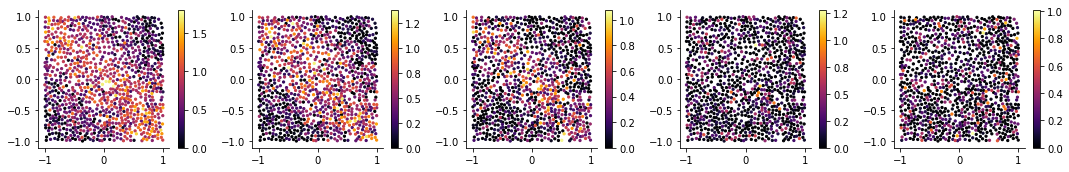

Num. of nulls: 100; Num. of non-nulls: 100
Generated matrix: (1045, 200)


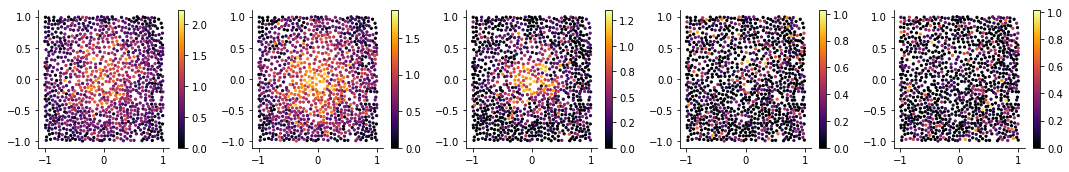

Num. of nulls: 100; Num. of non-nulls: 100
Generated matrix: (1045, 200)


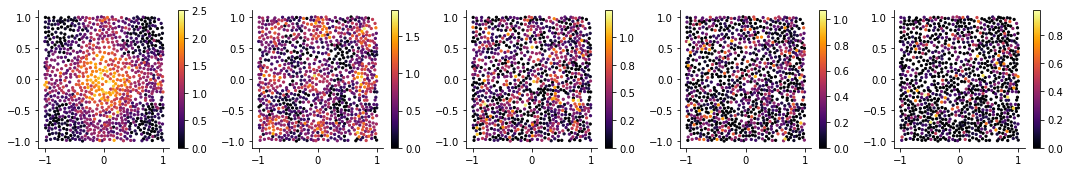

In [6]:
seeds = list(range(20))
temps = ['linear', 'diaquad', 'radial', 'cosine']

loc_fn = 'locs_2d.csv'
sim_fn = 'sim_setup.csv'
sdir = 'sim_data'

index = pd.MultiIndex.from_product([seeds, temps], names=["seed", "temp"])
sim_df = pd.DataFrame(index = index).reset_index()
sim_df['n_per_reg'] = 25
sim_df['n_regs'] = 4
sim_df['locs_fn'] = loc_fn
sim_df['expr_fn'] = sim_df.apply(lambda x: get_fname(sdir, x, 'mtx', 'csv'), axis=1)
print(sim_df.shape)
display(sim_df.head())

if save:
    sdir = os.path.join(sim_dir, sdir)
    os.makedirs(sdir, exist_ok=True)
    loc_fn = os.path.join(sim_dir, loc_fn)
    save_data_to_file(loc_df, loc_fn, 'csv')
    print('Saved locations to: {}'.format(loc_fn))

    sim_fn = os.path.join(sim_dir, sim_fn)
    save_data_to_file(sim_df, sim_fn, 'csv')
    print('Saved simparams to: {}'.format(sim_fn))
    
for i, val in sim_df.iterrows():
    mat_df = sim_2D_mtx(loc_df, val)
    mat_df = pd.DataFrame(mat_df)
    
    if save:
        fn = os.path.join(sim_dir, val['expr_fn'])
        save_data_to_file(mat_df, fn, 'csv')
        print('Saved matrix to: {}'.format(fn))